<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4: Predicting Presence of West Nile Virus <br>
**Notebook 4b: Modelling**

## TABLE OF CONTENTS

**1a. EDA on Training Dataset** <br>
**1b. EDA on Weather Dataset** <br>
**1c. EDA on Spray Dataset** <br>
**2. Data Preprocessing I** <br>
**3. Data Preprocessing II** <br>
**4a. Modelling (Pycaret)** <br>
**4b. Modelling (This Notebook)** <br>
- [(1) HyperParameter Tuning](#(1)-Gridsearch-for-Logistics-Regression,-Gradient-Boosting-Classfier,-and-Light-Gradient-Boosting-Machine-Models.) <br>
- [(2) Choosing a Production Model](#(2)-Choosing-a-Production-Model) <br>
- [(3) Examination of Most Important Variables](#(3)-Examination-of-Most-Important-Variables)
- [(4) Further Exploration](#(4)-Further-Exploration:-The-Case-for-Higher-Rolling-Days)
- [(5) Bonus: Logistics Regression with SMOTE](#(5)-Bonus:-Logistics-Regression-with-SMOTE)
- [(6) Bonus: Neural Nets Implementation](#(6)-Bonus:-Neural-Nets-Implementation)

**5. Cost Benefit Analysis** <br>
**6. Conclusion & Recommendations** <br>

In [1]:
import pandas as pd
import numpy as np

# for visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# For distance measuring given lat long
import geopy.distance

# for apply progress tracking
from tqdm import tqdm
tqdm.pandas()

from sklearn.pipeline import Pipeline

from sklearn.metrics import get_scorer, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, plot_roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

In [2]:
# Here we switch off the warnings as not all models being grid-searched converges
# Nevertheless, this is ok as the gridsearch will ultimately default to / compare models that converge

import warnings
warnings.filterwarnings("ignore")

# Modelling Overview

This section build-ups on [a broad scan of the classifier methods available using PyCaret.](./4a_Model_Scan_Pycaret.ipynb) Using AUC as a scoring criteria with CV as a validation method, we ascertained that Logistics Regression, Gradient Boosting Classifier and the Light Gradient Boosting Machine would be suitable methods to further develop our model upon. This section will see us conducting a gridsearch to optimise models built using said classifier methods, towards identifying a final production model for our use case.

## (1) Gridsearch for Logistics Regression, Gradient Boosting Classifier, and Light Gradient Boosting Machine Models.

Alongside identifying the best model for our case, we also seek to determine the optimal number of rolling days average to use for our weather-related variables. The use of such rolling days average reflects our theory about mosquito activity - that mosquito activity on a given day is not merely a function of the weather conditions on the day itself. 

Rather, peak mosquito activity arises as the culmination of hot and humid conditions over several days. This "number of days" accounts for (1) the duration of optimal weather required to "awake" and hatch the mosquito eggs from their wintry hibernation, (2) the number of days required for a newly-hatched mosquito larvae to fully mature into an adult mosquito, and (3) the presence of "good-weather" days for an adult mosquito to become fully active and be on the prowl for both mates and blood. 

For modelling purposes, we will use rolling averages of 10 days, 20 days, and 30 days in our models (a baseline model employing 1 rolling day will also be employed to validate our theory about mosquito activity). The best performing model will be used for our final production model.

### (a) Logistics Regression Modelling

In our logistics regression modelling, we used the "saga" solver and Ridge Regression exclusively as we found it to be the only solver-penalty combo that achieved convergence (sidenote: the "saga" solver was purpose-built for large dataset such as this). We also stratified our dataset based on our predicted variable for our train test data split, and set our class weights to "balanced" to accommodate the highly-imbalanced nature (~5% positive predictions) of our dataset. Lastly, we adopted Standard scaling for our weather-related variables, for both quicker convergence as well as the understanding that the large volume of weather could fit onto a standard scale. We further reduce the tolerance for convergence to 0.005 to accelerate the convergence process.

In [3]:
def log_reg_model(rolling_days, drop_codesum = False):
    
    # load in data
    locals()['train_' + str(rolling_days)] = pd.read_csv('./assets/Modelling_Data/train_r'+ str(rolling_days) +'.csv', index_col=0)
    
    # drop Date Column
    locals()['train_' + str(rolling_days)].drop(columns = ['Date'], inplace = True)
    
    # drop CodeSum Column
    if drop_codesum == True:
        locals()['train_' + str(rolling_days)].drop(columns = ['MIFG','TS','SQ','GR','VCFG','FG+','SN','FG',
                                                               'VCTS','BCFG','BR','RA','FU','DZ','TSRA','HZ'], inplace = True)
    
    # Create X and Y
    X = eval('train_' + str(rolling_days)).drop(columns = ['WnvPresent'])
    X.reset_index(drop = True, inplace = True)
    y = eval('train_' + str(rolling_days))['WnvPresent']
    
    # Dummify Columns
    X = pd.get_dummies(X, columns=['Species', 'Trap'], drop_first = True)
    
    # Train Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 88, stratify = y)
    
    #Standard Scale weather variables
    ct = ColumnTransformer([("sc", StandardScaler(), 
                             ['Tavg', 'PrecipTotal','StnPressure','ResultDir','AvgSpeed','Sunlight'])],
                          remainder = 'passthrough')

    X_train_sc = ct.fit_transform(X_train)
    X_test_sc = ct.transform(X_test)
    
    # Convert to dataframe
    X_train_sc = pd.DataFrame(X_train_sc, columns=X_train.columns)
    X_test_sc = pd.DataFrame(X_test_sc, columns=X_test.columns)
    
    # Instantiate a pipeline
    pipe_logreg = Pipeline([
        ('logreg', LogisticRegression(tol = 0.005, class_weight='balanced', solver = 'saga', max_iter=10000, random_state = 888)) # tuple for estimator object, class
    ])
    
    # Input Search Parameters!
    pipe_logreg_params = {'logreg__C':np.logspace(1,3,2)}
    
    # Instantiate a Grid Search
    gs_logreg = GridSearchCV(pipe_logreg, 
                             param_grid=pipe_logreg_params,
                             cv=5,
                             verbose=1,
                             n_jobs=-1
                            )

    # Score!
    gs_logreg.fit(X_train_sc, y_train) # 1. fit model on training data first

    for metric in ['accuracy', 'precision', 'recall', 'f1']: # define a list of metrics we want computed on test
        print(f'Train {metric}: {get_scorer(metric)(gs_logreg, X_train_sc, y_train)}') # pass to get_scorer for metrics computation
    print(f"Train AUC = {get_scorer('roc_auc')(gs_logreg, X_train_sc, y_train)}")

    for metric in ['accuracy', 'precision', 'recall', 'f1']: # define a list of metrics we want computed on test
        print(f'Test {metric}: {get_scorer(metric)(gs_logreg, X_test_sc, y_test)}') # pass to get_scorer for metrics computation
    print(f"Test AUC = {get_scorer('roc_auc')(gs_logreg, X_test_sc, y_test)}")
    
    return(gs_logreg)

#### Logistics Regression Across Different Rolling Days

**(i) 10 Rolling Days Average**

In [4]:
logreg_r10 = log_reg_model(10)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Train accuracy: 0.729507032248899
Train precision: 0.14352066883418485
Train recall: 0.8373983739837398
Train f1: 0.24504361617763679
Train AUC = 0.8530163779898668
Test accuracy: 0.7216613787135853
Test precision: 0.12607449856733524
Test recall: 0.7252747252747253
Test f1: 0.21480878763222133
Test AUC = 0.7966154849716494


**(ii) 20 Rolling Days Average**

In [5]:
logreg_r20 = log_reg_model(20)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Train accuracy: 0.7383151015769286
Train precision: 0.14844868735083533
Train recall: 0.8428184281842819
Train f1: 0.25243506493506496
Train AUC = 0.8606219248099528
Test accuracy: 0.7288722238246322
Test precision: 0.13275193798449614
Test recall: 0.7527472527472527
Test f1: 0.22570016474464583
Test AUC = 0.817625068994932


**(iii) 30 Rolling Day Average**

In [6]:
logreg_r30 = log_reg_model(30)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Train accuracy: 0.7459866458303737
Train precision: 0.1530562347188264
Train recall: 0.8482384823848238
Train f1: 0.2593206296603149
Train AUC = 0.8667595064256489
Test accuracy: 0.748774156331122
Test precision: 0.14666666666666667
Test recall: 0.7857142857142857
Test f1: 0.24719101123595508
Test AUC = 0.8267507986686069


**(iv) Baseline Model: Single Day Rolling Average**

In [7]:
logreg_r1 = log_reg_model(1)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Train accuracy: 0.677368944452337
Train precision: 0.11497975708502024
Train recall: 0.7696476964769647
Train f1: 0.20007044734061288
Train AUC = 0.8052638314988847
Test accuracy: 0.6795500432650706
Test precision: 0.11323896752706078
Test recall: 0.7472527472527473
Test f1: 0.19667389732465654
Test AUC = 0.7634410490574874


**We note the following:**

(1) That the **logistic regression model achieved respectable performance, with the best performing model using a 30 days rolling average (0.867 Train AUC and 0.827 Test AUC)**. 

(2) That all models employing a rolling average for our weather-related parameters performed vastly more superior than the model using only "actual day" (i.e. rolling day of 1) weather conditions. This **validates our theory that peak mosquito activity is the culmination of conducive weather over many days, and not just a single day**.

In [9]:
## Examination of best parameters
logreg_r30.best_params_

{'logreg__C': 1000.0}

### (b) Gradient Boosting Classifier Modelling

We model using the Gradient Boosting Classifier next, conducting a gridsearch over different depth, number of estimators, and learning rates. Likewise, we adopted measures to accommodate the highly imbalanced dataset, as well as Standard scaling for our weather-related variables.

In [10]:
def grad_boost_model(rolling_days, drop_codesum = False):
    
    # load in data
    locals()['train_' + str(rolling_days)] = pd.read_csv('./assets/Modelling_Data/train_r'+ str(rolling_days) +'.csv', index_col=0)
    
    # drop Date Column
    locals()['train_' + str(rolling_days)].drop(columns = ['Date'], inplace = True)
    
    # drop CodeSum Column
    if drop_codesum == True:
        locals()['train_' + str(rolling_days)].drop(columns = ['MIFG','TS','SQ','GR','VCFG','FG+','SN','FG',
                                                               'VCTS','BCFG','BR','RA','FU','DZ','TSRA','HZ'], inplace = True)
    
    # Create X and Y
    X = eval('train_' + str(rolling_days)).drop(columns = ['WnvPresent'])
    X.reset_index(drop = True, inplace = True)
    y = eval('train_' + str(rolling_days))['WnvPresent']
    
    # Dummify Columns
    X = pd.get_dummies(X, columns=['Species', 'Trap'], drop_first = True)
    
    # Train Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 88, stratify = y)
    
    #Standard Scale weather variables
    ct = ColumnTransformer([("sc", StandardScaler(), 
                             ['Tavg', 'PrecipTotal','StnPressure','ResultDir','AvgSpeed','Sunlight'])],
                          remainder = 'passthrough')

    X_train_sc = ct.fit_transform(X_train)
    X_test_sc = ct.transform(X_test)
    
    # Convert to dataframe
    X_train_sc = pd.DataFrame(X_train_sc, columns=X_train.columns)
    X_test_sc = pd.DataFrame(X_test_sc, columns=X_test.columns)
    
        
    # Instantiate a pipeline
    pipe_gradboost = Pipeline([
        ('gradboost', GradientBoostingClassifier(random_state = 88)) # tuple for estimator object, class
    ])
    
    # Input Search Parameters!
    pipe_gradboost_params = {'gradboost__max_depth': [3,4],
                             'gradboost__n_estimators': [50, 75],
                             'gradboost__learning_rate': [.08, .1, .12]}
    
    # Instantiate a Grid Search
    gs_gradboost = GridSearchCV(pipe_gradboost, 
                                param_grid=pipe_gradboost_params,
                                cv=5,
                                verbose=1,
                                n_jobs=-1
                               )

    # Score!
    gs_gradboost.fit(X_train_sc, y_train) # 1. fit model on training data first

    for metric in ['accuracy', 'precision', 'recall', 'f1']: # define a list of metrics we want computed on test
        print(f'Train {metric}: {get_scorer(metric)(gs_gradboost, X_train_sc, y_train)}') # pass to get_scorer for metrics computation
    print(f"Train AUC = {get_scorer('roc_auc')(gs_gradboost, X_train_sc, y_train)}")

    for metric in ['accuracy', 'precision', 'recall', 'f1']: # define a list of metrics we want computed on test
        print(f'Test {metric}: {get_scorer(metric)(gs_gradboost, X_test_sc, y_test)}') # pass to get_scorer for metrics computation
    print(f"Test AUC = {get_scorer('roc_auc')(gs_gradboost, X_test_sc, y_test)}")
    
    return(gs_gradboost)

#### Gradient Boosting Classifier Across Different Rolling Days

**(i) 10 Rolling Days Average**

In [11]:
gradboost_r10 = grad_boost_model(10)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Train accuracy: 0.9492825685466686
Train precision: 1.0
Train recall: 0.032520325203252036
Train f1: 0.06299212598425198
Train AUC = 0.8781942362152257
Test accuracy: 0.9475050475915777
Test precision: 0.5
Test recall: 0.01098901098901099
Test f1: 0.021505376344086023
Test AUC = 0.8394617559001121


**(ii) 20 Rolling Days Average**

In [12]:
gradboost_r20 = grad_boost_model(20)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Train accuracy: 0.9495666998153147
Train precision: 0.85
Train recall: 0.04607046070460705
Train f1: 0.08740359897172237
Train AUC = 0.8734980070940139
Test accuracy: 0.9480819152004615
Test precision: 0.75
Test recall: 0.016483516483516484
Test f1: 0.03225806451612903
Test AUC = 0.8358748557378695


**(iii) 30 Rolling Day Average**

In [13]:
gradboost_r30 = grad_boost_model(30)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Train accuracy: 0.9502770279869299
Train precision: 0.7317073170731707
Train recall: 0.08130081300813008
Train f1: 0.14634146341463414
Train AUC = 0.8812390552691134
Test accuracy: 0.9489472166137871
Test precision: 0.6666666666666666
Test recall: 0.054945054945054944
Test f1: 0.1015228426395939
Test AUC = 0.8451126499071704


**(iv) Baseline Model: Single Day Rolling Average**

In [14]:
gradboost_r1 = grad_boost_model(1)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Train accuracy: 0.9487143060093763
Train precision: 0.8333333333333334
Train recall: 0.02710027100271003
Train f1: 0.05249343832020998
Train AUC = 0.8673750523112428
Test accuracy: 0.946928179982694
Test precision: 0.0
Test recall: 0.0
Test f1: 0.0
Test AUC = 0.8270225968856106


The gradient boosting classifier achieved superior performance relative to the logistics regression, with the 30 days rolling average achieving a 0.881 Train AUC and 0.845 Test AUC.

By now, it should be beyond disputing the rolling average model is far superior than a single day weather model.

In [15]:
## Examination of best parameters
gradboost_r30.best_params_

{'gradboost__learning_rate': 0.08,
 'gradboost__max_depth': 3,
 'gradboost__n_estimators': 50}

### (c) Light Gradient Boosting Machine Modelling

We model using the Light Gradient Boosting Machine ([Ref.1](https://www.geeksforgeeks.org/lightgbm-light-gradient-boosting-machine/)) ([Ref.2](https://www.kaggle.com/code/prashant111/lightgbm-classifier-in-python)) next.  Theoretically, the light gradient boosting machine enhances upon the Gradient Boosting Classifier by incorporating features that (1) builds a lighter tree by only focusing on splits for under-trained variables, thereby maximising information gain in a "lighter tree”, and (2) the bundling of sparse, uncorrelated variables, thereby allowing for faster convergence.  

We conducting a gridsearch over different number of estimators, and learning rates. Likewise, we adopted measures to accommodate the highly imbalanced dataset, as well as Standard scaling for our weather-related variables.

In [16]:
def light_boost_model(rolling_days, drop_codesum = False):
    
    # load in data
    locals()['train_' + str(rolling_days)] = pd.read_csv('./assets/Modelling_Data/train_r'+ str(rolling_days) +'.csv', index_col=0)
    
    # drop Date Column
    locals()['train_' + str(rolling_days)].drop(columns = ['Date'], inplace = True)
    
    # drop CodeSum Column
    if drop_codesum == True:
        locals()['train_' + str(rolling_days)].drop(columns = ['MIFG','TS','SQ','GR','VCFG','FG+','SN','FG',
                                                               'VCTS','BCFG','BR','RA','FU','DZ','TSRA','HZ'], inplace = True)
    
    # Create X and Y
    X = eval('train_' + str(rolling_days)).drop(columns = ['WnvPresent'])
    X.reset_index(drop = True, inplace = True)
    y = eval('train_' + str(rolling_days))['WnvPresent']
    
    # Dummify Columns
    X = pd.get_dummies(X, columns=['Species', 'Trap'], drop_first = True)
    
    # Train Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 88, stratify = y)
    
    #Standard Scale weather variables
    ct = ColumnTransformer([("sc", StandardScaler(), 
                             ['Tavg', 'PrecipTotal','StnPressure','ResultDir','AvgSpeed','Sunlight'])],
                          remainder = 'passthrough')

    X_train_sc = ct.fit_transform(X_train)
    X_test_sc = ct.transform(X_test)
    
    # Convert to dataframe
    X_train_sc = pd.DataFrame(X_train_sc, columns=X_train.columns)
    X_test_sc = pd.DataFrame(X_test_sc, columns=X_test.columns)
    
        
    # Instantiate a pipeline
    pipe_lgb = Pipeline([
        ('lgb', lgb.LGBMClassifier(random_state = 88)) # tuple for estimator object, class
    ])
    
    # Input Search Parameters!
    pipe_lgb_params = {'lgb__n_estimators': [50, 75],
                       'lgb__learning_rate': [.08, .1, .12],
                       'lgb__max_depth': [3,5,10],
                      }
    
    # Instantiate a Grid Search
    gs_lgb = GridSearchCV(pipe_lgb, 
                          param_grid=pipe_lgb_params,
                          cv=5,
                          verbose=1,
                          n_jobs=-1
                         )

    # Score!
    gs_lgb.fit(X_train_sc, y_train) # 1. fit model on training data first

    for metric in ['accuracy', 'precision', 'recall', 'f1']: # define a list of metrics we want computed on test
        print(f'Train {metric}: {get_scorer(metric)(gs_lgb, X_train_sc, y_train)}') # pass to get_scorer for metrics computation
    print(f"Train AUC = {get_scorer('roc_auc')(gs_lgb, X_train_sc, y_train)}")

    for metric in ['accuracy', 'precision', 'recall', 'f1']: # define a list of metrics we want computed on test
        print(f'Test {metric}: {get_scorer(metric)(gs_lgb, X_test_sc, y_test)}') # pass to get_scorer for metrics computation
    print(f"Test AUC = {get_scorer('roc_auc')(gs_lgb, X_test_sc, y_test)}")
    
    return(gs_lgb)

#### Light Gradient Booster Across Different Rolling Days

**(i) 10 Rolling Days Average**

In [17]:
lightboost_r10 = light_boost_model(10)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Train accuracy: 0.948003977837761
Train precision: 1.0
Train recall: 0.008130081300813009
Train f1: 0.01612903225806452
Train AUC = 0.907648817867489
Test accuracy: 0.9475050475915777
Test precision: 0.0
Test recall: 0.0
Test f1: 0.0
Test AUC = 0.8596919062672488


**(ii) 20 Rolling Days Average**

In [18]:
lightboost_r20 = light_boost_model(20)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Train accuracy: 0.9488563716436994
Train precision: 0.7647058823529411
Train recall: 0.03523035230352303
Train f1: 0.06735751295336788
Train AUC = 0.914427745476855
Test accuracy: 0.9477934813960196
Test precision: 0.6
Test recall: 0.016483516483516484
Test f1: 0.0320855614973262
Test AUC = 0.8462675832538846


**(iii) 30 Rolling Day Average**

In [19]:
lightboost_r30 = light_boost_model(30)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Train accuracy: 0.9492825685466686
Train precision: 0.8333333333333334
Train recall: 0.04065040650406504
Train f1: 0.07751937984496124
Train AUC = 0.920021899619296
Test accuracy: 0.9495240842226709
Test precision: 1.0
Test recall: 0.038461538461538464
Test f1: 0.07407407407407407
Test AUC = 0.8558833860203724


**(iv) Baseline Model: Single Day Rolling Average**

In [20]:
lightboost_r1 = light_boost_model(1)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Train accuracy: 0.9475777809347918
Train precision: 0.0
Train recall: 0.0
Train f1: 0.0
Train AUC = 0.863284008402303
Test accuracy: 0.9475050475915777
Test precision: 0.0
Test recall: 0.0
Test f1: 0.0
Test AUC = 0.8352133406927927


The gradient boosting classifier achieved seemingly achieved superior performance relative to both the logistics regression and gradient boosting classifier.  **The 30 days rolling average achieved the best results of all with a 0.918 Train AUC and a 0.852 Test AUC.**

However, we note that the light gradient boosting model produces instances of exceptionally severe overfitting.

In [21]:
## Examination of best parameters
lightboost_r10.best_params_

{'lgb__learning_rate': 0.08, 'lgb__max_depth': 5, 'lgb__n_estimators': 50}

# (2) Choosing a Production Model

Following a Gridsearch for the optimal parameters of our candidate models, we ascertained that the Light Gradient Boosting Model achieved the best results. However, we are mindful of the following:

(1) **The performance of the light boosting gradient method was only marginally better**. This also came at a cost of much more severe overfitting by the light gradient boosting model as opposed to say, the Logistics Regression Model. Consequently, the light gradient boosting model might not fit as well on new, unseen data.

(2) **Among the candidate models, the logistics regression model provides best "white box" explanability**. A non-technical audience can better sieve out key factors leading to WNV onset, and correspondingly adopt measures to tackle the virus. This model will ultimately be more palatable to the non-technical city management. 

With the above consideration, **we deem the logistics regression model to be most suitable for production.**

## ROC Curve for Chosen Model

In [22]:
def log_reg_model_selected(rolling_days, drop_codesum = False):
    
    # load in data
    locals()['train_' + str(rolling_days)] = pd.read_csv('./assets/Modelling_Data/train_r'+ str(rolling_days) +'.csv', index_col=0)
    
    # drop Date Column
    locals()['train_' + str(rolling_days)].drop(columns = ['Date'], inplace = True)
    
    # drop CodeSum Column
    if drop_codesum == True:
        locals()['train_' + str(rolling_days)].drop(columns = ['MIFG','TS','SQ','GR','VCFG','FG+','SN','FG',
                                                               'VCTS','BCFG','BR','RA','FU','DZ','TSRA','HZ'], inplace = True)
    
    # Create X and Y
    X = eval('train_' + str(rolling_days)).drop(columns = ['WnvPresent'])
    X.reset_index(drop = True, inplace = True)
    y = eval('train_' + str(rolling_days))['WnvPresent']
    
    # Dummify Columns
    X = pd.get_dummies(X, columns=['Species', 'Trap'], drop_first = True)
    
    # Train Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 88, stratify = y)
    
    #Standard Scale weather variables
    ct = ColumnTransformer([("sc", StandardScaler(), 
                             ['Tavg', 'PrecipTotal','StnPressure','ResultDir','AvgSpeed','Sunlight'])],
                           remainder = 'passthrough')

    X_train_sc = ct.fit_transform(X_train)
    X_test_sc = ct.transform(X_test)
    
    # Convert to dataframe
    X_train_sc = pd.DataFrame(X_train_sc, columns=X_train.columns)
    X_test_sc = pd.DataFrame(X_test_sc, columns=X_test.columns)
    
    # Instantiate a pipeline
    logreg = LogisticRegression(class_weight='balanced', solver = 'saga', max_iter= 10000, C = 1000)

    # Score!
    logreg.fit(X_train_sc, y_train) # 1. fit model on training data first
    print(f"Test AUC = {get_scorer('roc_auc')(logreg, X_test_sc, y_test)}")
    
    return(logreg, X_test_sc, y_test)

In [23]:
model, X_test, y_test= log_reg_model_selected(30)

Test AUC = 0.8280872095940589


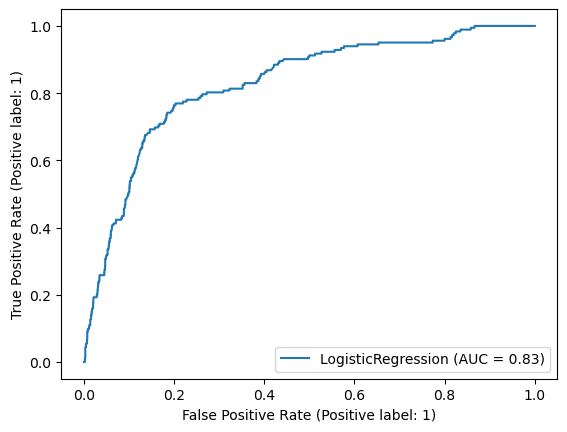

In [24]:
plot_roc_curve(model, X_test, y_test)
plt.show();

## Logistic Regression Function for Final Production

To set our chosen model for production, we retrain the Logistic Regression model using the entire train set, before publishing our predicted values into a separate csv file.

**Submitting our results to Kaggle, where we achieved an AUC score of 0.751.**

In [37]:
def logregger(rolling_days, drop_codesum = False):
    
    
    # Obtain Data Set
    train = pd.read_csv('./assets/Modelling_Data/train_r' + str(rolling_days) +'.csv', index_col=0)
    test = pd.read_csv('./assets/Modelling_Data/test_r' + str(rolling_days) +'.csv', index_col=0)
    
    # Drop Date Column
    train.drop(columns = ['Date'], inplace = True)
    test.drop(columns = ['Date', 'Id'], inplace = True)
    
    # drop CodeSum Column
    if drop_codesum == True:
        train.drop(columns = ['MIFG','TS','SQ','GR','VCFG','FG+','SN','FG',
                              'VCTS','BCFG','BR','RA','FU','DZ','TSRA','HZ'], inplace = True)
        test.drop(columns = ['MIFG','TS','SQ','GR','VCFG','FG+','SN','FG',
                              'VCTS','BCFG','BR','RA','FU','DZ','TSRA','HZ'], inplace = True)
        
    
    # Create X and Y
    X_train = train.drop(columns = ['WnvPresent'])
    y_train = train['WnvPresent']
    
    # Dummify Columns
    X_train_dummy = pd.get_dummies(X_train, columns=['Species', 'Trap'], drop_first = True)
    X_test_dummy = pd.get_dummies(test, columns=['Species', 'Trap'], drop_first = True)
    
    # Standard Scale weather variables
    ct = ColumnTransformer([("sc", StandardScaler(), 
                         ['Tavg', 'PrecipTotal','StnPressure','ResultDir','AvgSpeed','Sunlight'])],
                      remainder = 'passthrough')

    X_train_dummy_sc = ct.fit_transform(X_train_dummy)
    X_test_dummy_sc = ct.transform(X_test_dummy)
    
    # Convert back to data frame with columns
    X_train_final = pd.DataFrame(X_train_dummy_sc, columns=X_train_dummy.columns)
    X_test_final = pd.DataFrame(X_test_dummy_sc, columns=X_train_dummy.columns)
    
    # Fit model on train
    logreg = LogisticRegression(class_weight='balanced', solver = 'saga', max_iter = 40000, C = 1000)
    logreg.fit(X_train_final,y_train)
    
    # Prepare dataframe
    answer = pd.DataFrame(logreg.predict_proba(X_test_final))
    answer.drop(columns =[0], inplace = True)
    answer = pd.concat([pd.DataFrame(np.linspace(1,len(answer),num=len(answer))), answer],axis = 1)
    answer.rename(mapper= {0:'Id',1:'WnvPresent'}, axis = 1, inplace = True)
    answer['Id'] = answer['Id'].astype(np.int64)
    
    # Export file to submissions folder
    if drop_codesum == True:
        answer.to_csv('./assets/Submissions/r' + str(rolling_days) +'_lr_dropped.csv', index = False)
    else: 
        answer.to_csv('./assets/Submissions/r' + str(rolling_days) +'_lr.csv', index = False)
        
    return((logreg,X_train_final))

In [38]:
# Export Output of Model
results = logregger(30)
production_model = results[0]
X_train_final = results[1]

# (3) Examination of Most Important Variables

Examining the most important variables, we discover the following to impact the onset of WNV most significantly:

(1) **Precipitation (Most Positive)**. Presence of rain / drizzle casts the greatest impact in causing WNV onset.

(2) **Fogs and Smoke (Most Negative)**. Meanwhile, the presence of Mist / Fog / Smoke deters the onset of WNV most significantly!

In [39]:
# Examine most important variables
coefficients = pd.DataFrame(production_model.coef_, columns = X_train_final.columns)

In [40]:
## Variables with Highest Coefficients (Positive)
(coefficients.T)[0].sort_values(ascending=False)[0:5]

BCFG    44.345991
DZ      10.853193
RA       6.740013
FG       6.492740
VCTS     5.513570
Name: 0, dtype: float64

In [41]:
## Variables with Highest Coefficients (Negative)
(coefficients.T)[0].sort_values(ascending=True)[0:5]

VCFG   -78.814172
SQ     -47.459589
GR     -27.759586
FG+    -25.778627
MIFG    -8.802805
Name: 0, dtype: float64

# (4) Further Exploration: The Case for Higher Rolling Days

We have earlier experimented with rolling weather averages of 10, 20 and 30 days for our model. The key idea is these number of days should adequately account for the duration of optimal weather required for mosquito eggs to "unhibernate", to hatch, and for the adults to become sufficiently active. However, while we can scientifically establish that it takes 8 to 10 days for a hatched mosquito egg to become an adult, the science behind how animals regulate themselves to wake up from hibernation is more abstract.

By some accounts, animal wakes up from hibernation using some combination of [internal body clock](https://earthsky.org/earth/how-do-hibernating-animals-know-when-to-wake-up/) and [external weather stimulus](https://www.grunge.com/1055546/how-do-hibernating-animals-know-when-to-wake-up/). Of note, waking up from hibernation is a massive endeavour for most animals requiring them to turn on many calorie-burning bodily functions - waking up too early can spell doom for hibernating animals. The point is, animals may take even longer-term weather averages into account when deciding to come out of hibernation. It is therefore not unthinkable that even rolling day averages beyond 30 days could be a key factor when determining mosquito activity. 

In a exploratory instance, we used a rolling average of 80 days to train a logistics model (here we drop the CodeSum variables since we opine that these variables loses their significance over so many days).

**Submitting the results to Kaggle, we obtain an AUC score of 0.790**, which is slightly superior to our previous results. Is this due to sheer luck? The hibernation behaviour of mosquito eggs is certainly worth further examination.

In [79]:
# Trying for more outlandish days...
logregger_80 = logregger(80, drop_codesum = True)

![image](https://yohta-blog.yokohama-oht.com/hs-fs/hubfs/well-its-groundhog-day-again.jpg?width=1000&height=720&name=well-its-groundhog-day-again.jpg)

# (5) Bonus: Logistics Regression with SMOTE

We took the liberty to explore an alternate method [Synthetic Minority Oversampling Technique](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/). This technique synthesises the under-represented observations (in this case,'WnvPresent' = 1) by applying KNN on the observations to create more data points, towards creating a more balanced dataset. Theoretically, this prevents an "over-learning" of the the limited positive cases we have, thereby mitigating any overfit. However, it also [documented](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwjl-u64k_z6AhWNm9gFHQeID3sQFnoECBUQAw&url=https%3A%2F%2Fwww.mdpi.com%2F2073-8994%2F13%2F2%2F194%2Fpdf&usg=AOvVaw00Iv0stQnUPpsP4dEGfoUF) that the model oversamples noises (which in turn aggravates overfitting).

The method produced slightly superior results. However, the more severe overfitting leads us to decide against using the model for our final production.

In [36]:
from imblearn.over_sampling import SMOTE

### Function for SMOTE-Enabled Logistic Regression Training

In [37]:
def log_reg_model_SMOTE(rolling_days, drop_codesum = False):
    
    print(f"LOG REG with SMOTE: {rolling_days} days rolling weather.") 
    
    # load in data
    locals()['train_' + str(rolling_days)] = pd.read_csv('./assets/Modelling_Data/train_r'+ str(rolling_days) +'.csv', index_col=0)
    
    # drop Date Column
    locals()['train_' + str(rolling_days)].drop(columns = ['Date'], inplace = True)
    
    # drop CodeSum Column
    if drop_codesum == True:
        locals()['train_' + str(rolling_days)].drop(columns = ['MIFG','TS','SQ','GR','VCFG','FG+','SN','FG',
                                                               'VCTS','BCFG','BR','RA','FU','DZ','TSRA','HZ'], inplace = True)
        
    # Create X and Y
    X = eval('train_' + str(rolling_days)).drop(columns = ['WnvPresent'])
    X.reset_index(drop = True, inplace = True)
    y = eval('train_' + str(rolling_days))['WnvPresent']
    
    # Dummify Columns
    X = pd.get_dummies(X, columns=['Species', 'Trap'], drop_first = True)
    
    # Train Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 88, stratify = y)
    
    # Standard Scale weather variables
    ct = ColumnTransformer([("sc", StandardScaler(), 
                             ['Tavg', 'PrecipTotal','StnPressure','ResultDir','AvgSpeed','Sunlight'])],
                          remainder = 'passthrough')

    X_train_sc = ct.fit_transform(X_train)
    X_test_sc = ct.transform(X_test)
    
    # Convert to dataframe
    X_train_sc = pd.DataFrame(X_train_sc, columns=X_train.columns)
    X_test_sc = pd.DataFrame(X_test_sc, columns=X_test.columns)
    
    # SMOTE HERE
    sm = SMOTE(random_state=42)
    X_train_sc, y_train = sm.fit_resample(X_train_sc, y_train)
    
    # Instantiate a pipeline
    pipe_logreg = Pipeline([
        ('logreg', LogisticRegression(class_weight='balanced', solver = 'saga', max_iter=10000)) # tuple for estimator object, class
    ])
    
    # Input Search Parameters!
    pipe_logreg_params = {'logreg__C': np.logspace(-3,3,7)}
    
    # Instantiate a Grid Search
    gs_logreg = GridSearchCV(pipe_logreg, 
                             param_grid=pipe_logreg_params,
                             cv=5,
                             verbose=1,
                             n_jobs=-1
                            )
    
    # Score!
    
    gs_logreg.fit(X_train_sc, y_train) # 1. fit model on training data first

    for metric in ['accuracy', 'precision', 'recall', 'f1']: # define a list of metrics we want computed on test
        print(f'Train {metric}: {get_scorer(metric)(gs_logreg, X_train_sc, y_train)}') # pass to get_scorer for metrics computation
    print(f"Train AUC = {get_scorer('roc_auc')(gs_logreg, X_train_sc, y_train)}")

    for metric in ['accuracy', 'precision', 'recall', 'f1']: # define a list of metrics we want computed on test
        print(f'Test {metric}: {get_scorer(metric)(gs_logreg, X_test_sc, y_test)}') # pass to get_scorer for metrics computation
    print(f"Test AUC = {get_scorer('roc_auc')(gs_logreg, X_test_sc, y_test)}")
    
    print('**************************************************')    
        
    return(gs_logreg)

In [38]:
logreg_smote_r30 = log_reg_model_SMOTE(30)

LOG REG with SMOTE: 30 days rolling weather.
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Train accuracy: 0.818215892053973
Train precision: 0.785704670884372
Train recall: 0.8751124437781109
Train f1: 0.8280019859564508
Train AUC = 0.8860695364461696
Test accuracy: 0.7683876550331699
Test precision: 0.1569060773480663
Test recall: 0.7802197802197802
Test f1: 0.2612695492180313
Test AUC = 0.8272575978055432
**************************************************


### Function for SMOTE-Enabled Logistic Regression Submission (Not Used)

In [39]:
def logregger_smote(rolling_days, drop_codesum = False):
    
    # Obtain Data Set
    train = pd.read_csv('./assets/Modelling_Data/train_r' + str(rolling_days) +'.csv', index_col=0)
    test = pd.read_csv('./assets/Modelling_Data/test_r' + str(rolling_days) +'.csv', index_col=0)
    
    # Drop Date Column
    train.drop(columns = ['Date'], inplace = True)
    test.drop(columns = ['Date', 'Id'], inplace = True)
    
    # drop CodeSum Column
    if drop_codesum == True:
        train.drop(columns = ['MIFG','TS','SQ','GR','VCFG','FG+','SN','FG',
                              'VCTS','BCFG','BR','RA','FU','DZ','TSRA','HZ'], inplace = True)
        test.drop(columns = ['MIFG','TS','SQ','GR','VCFG','FG+','SN','FG',
                              'VCTS','BCFG','BR','RA','FU','DZ','TSRA','HZ'], inplace = True)    
    
    # Create X and Y
    X_train = train.drop(columns = ['WnvPresent'])
    y_train = train['WnvPresent']
    
    # Dummify Columns
    X_train_dummy = pd.get_dummies(X_train, columns=['Species', 'Trap'], drop_first = True)
    X_test_dummy = pd.get_dummies(test, columns=['Species', 'Trap'], drop_first = True)
    
    # Standard Scale weather variables
    ct = ColumnTransformer([("sc", StandardScaler(), 
                         ['Tavg', 'PrecipTotal','StnPressure','ResultDir','AvgSpeed','Sunlight'])],
                      remainder = 'passthrough')

    X_train_dummy_sc = ct.fit_transform(X_train_dummy)
    X_test_dummy_sc = ct.transform(X_test_dummy)
    
    # Convert back to data frame with columns
    X_train_final = pd.DataFrame(X_train_dummy_sc, columns=X_train_dummy.columns)
    X_test_final = pd.DataFrame(X_test_dummy_sc, columns=X_train_dummy.columns)
    
    # Apply SMOTE to expand data set
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X_train_final, y_train)
    
    # Fit model on train
    logreg = LogisticRegression(penalty = 'l2', solver = 'sag', C = 1.0, max_iter=1000)
    logreg.fit(X_res,y_res)
    
    # Prepare dataframe
    answer = pd.DataFrame(logreg.predict_proba(X_test_final))
    answer.drop(columns =[0], inplace = True)
    answer = pd.concat([pd.DataFrame(np.linspace(1,len(answer),num=len(answer))), answer],axis = 1)
    answer.rename(mapper= {0:'Id',1:'WnvPresent'}, axis = 1, inplace = True)
    answer['Id'] = answer['Id'].astype(np.int64)
    
    # Export file to submissions folder
    if drop_codesum == True:
        answer.to_csv('./assets/Submissions/r' + str(rolling_days) +'_lr_dropped_smote.csv', index = False)
    else: 
        answer.to_csv('./assets/Submissions/r' + str(rolling_days) +'_lr_smote.csv', index = False)

# (6) Bonus: Neural Nets Implementation

We experimented with the implementation of a neural net for WNV prediction. With the caveat that we did not perform a train set cross-validation nor did we finetune the model, we were not able to obtain a better performance than what we already have (AUC of 0.73 when submitted to Kaggle). Concurrently, the model displayed difficulties in converging, and we opine that it is best to not use it for production.

In [42]:
from sklearn.neural_network import MLPClassifier

In [43]:
def neural_nets(rolling_days, drop_codesum = False):
    
    # Obtain Data Set
    train = pd.read_csv('./assets/Modelling_Data/train_r' + str(rolling_days) +'.csv', index_col=0)
    test = pd.read_csv('./assets/Modelling_Data/test_r' + str(rolling_days) +'.csv', index_col=0)
    
    # Drop Date Column
    train.drop(columns = ['Date'], inplace = True)
    test.drop(columns = ['Date', 'Id'], inplace = True)
    
    # drop CodeSum Column
    if drop_codesum == True:
        train.drop(columns = ['MIFG','TS','SQ','GR','VCFG','FG+','SN','FG',
                              'VCTS','BCFG','BR','RA','FU','DZ','TSRA','HZ'], inplace = True)
        test.drop(columns = ['MIFG','TS','SQ','GR','VCFG','FG+','SN','FG',
                              'VCTS','BCFG','BR','RA','FU','DZ','TSRA','HZ'], inplace = True)
        
    
    # Create X and Y
    X_train = train.drop(columns = ['WnvPresent'])
    y_train = train['WnvPresent']
    
    # Dummify Columns
    X_train_dummy = pd.get_dummies(X_train, columns=['Species', 'Trap'], drop_first = True)
    X_test_dummy = pd.get_dummies(test, columns=['Species', 'Trap'], drop_first = True)
    
    # Standard Scale weather variables
    ct = ColumnTransformer([("sc", StandardScaler(), 
                         ['Tavg', 'PrecipTotal','StnPressure','ResultDir','AvgSpeed','Sunlight'])],
                      remainder = 'passthrough')

    X_train_dummy_sc = ct.fit_transform(X_train_dummy)
    X_test_dummy_sc = ct.transform(X_test_dummy)
    
    # Convert back to data frame with columns
    X_train_final = pd.DataFrame(X_train_dummy_sc, columns=X_train_dummy.columns)
    X_test_final = pd.DataFrame(X_test_dummy_sc, columns=X_train_dummy.columns)
    
    # Fit model on train
    nn = MLPClassifier(hidden_layer_sizes = (50,100,150,100,50), 
                       random_state = 88, 
                       learning_rate = 'adaptive',
                       alpha = 0.05
                      )
    nn.fit(X_train_final,y_train)
    
    # Prepare dataframe
    answer = pd.DataFrame(nn.predict_proba(X_test_final))
    answer.drop(columns =[0], inplace = True)
    answer = pd.concat([pd.DataFrame(np.linspace(1,len(answer),num=len(answer))), answer],axis = 1)
    answer.rename(mapper= {0:'Id',1:'WnvPresent'}, axis = 1, inplace = True)
    answer['Id'] = answer['Id'].astype(np.int64)
    
    # Export file to submissions folder
    if drop_codesum == True:
        answer.to_csv('./assets/Submissions/r' + str(rolling_days) +'_nn_dropped.csv', index = False)
    else: 
        answer.to_csv('./assets/Submissions/r' + str(rolling_days) +'_nn.csv', index = False)
        
    return((nn,X_train_final))

In [45]:
#%%time
nn_model = neural_nets(30, drop_codesum = True)